In [21]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data'

print('슝=3')

슝=3


In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


2025-03-10 23:06:47.146613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


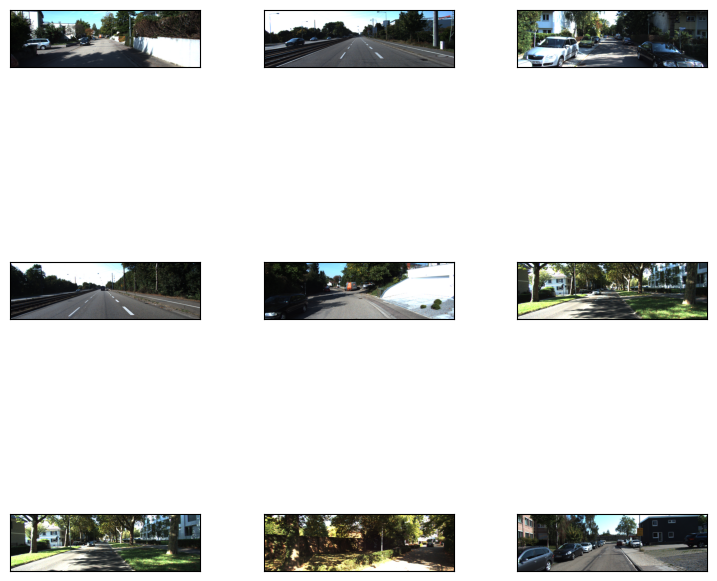

In [23]:
_ = tfds.show_examples(ds_train, ds_info)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-2.01,  1.92, -1.93, -1.8 , -1.75,  1.65, -1.7 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.18186666, 0.74190015, 0.49984   , 0.8036715 ],
       [0.00266667, 0.08744767, 0.48042667, 0.3595974 ],
       [0.00266667, 0.6150725 , 0.53128   , 0.90697265],
       [0.21274666, 0.574058  , 0.49658668, 0.69640905],
       [0.31757334, 0.54619163, 0.54981333, 0.63347024],
       [0.42213333, 0.41983092, 0.52672   , 0.457971  ],
       [0.41965333, 0.5287842 , 0.55461335, 0.5732367 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.44, 0.36, 1.26],
       [1.46, 1.6 , 3.33],
       [1.64, 1.7 , 3.54],
       [1.37, 1.51, 3.39],
       [1.74, 1.66, 4.23],
       [1.55, 1.68, 4.42],
       [2.  , 1.76, 4.61]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

2025-03-10 23:26:35.843963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


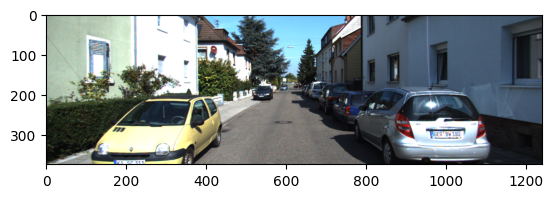

In [38]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [39]:
# 첫 번째 샘플 가져오기
for example in sample:  
    bbox = example['objects']['bbox'].numpy()  # Bounding Box 데이터 추출
    print("Bounding Boxes (ymin, xmin, ymax, xmax):\n", bbox)

Bounding Boxes (ymin, xmin, ymax, xmax):
 [[0.00991979 0.90257674 0.608262   0.9728514 ]
 [0.3375936  0.3129564  0.57187164 0.33692247]
 [0.16029412 0.22962843 0.56566846 0.27378836]
 [0.40101606 0.52710825 0.5389038  0.55      ]
 [0.38286096 0.41959614 0.5509358  0.4352181 ]
 [0.42144385 0.4647496  0.5568449  0.47739902]
 [0.43122995 0.51125205 0.55799466 0.5236349 ]
 [0.46216577 0.5015105  0.55320853 0.5101292 ]
 [0.13703209 0.5883118  0.85703206 0.82077545]]


2025-03-10 23:26:39.306901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 바운딩 박스 그릴 때 좌표를 그대로 가로/세로를 곱해 변환하면, y값이 이상하게 나와서 반전을 적용했습니다

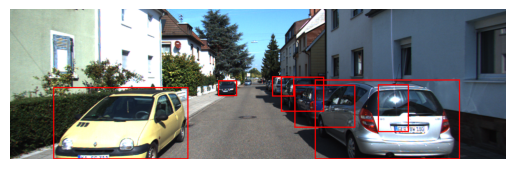

In [119]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요

def visualize_bbox(input_image, object_bboxes):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    img_width, img_height = input_image.size  # 이미지 크기 가져오기

    for bbox in object_bboxes:  # 여러 개의 바운딩 박스를 하나씩 처리
        ymin, xmin, ymax, xmax = bbox  # 개별 바운딩 박스 좌표 가져오기

        x_min = int(xmin * img_width)
        x_max = int(xmax * img_width)
        y_min = img_height - int(ymin * img_height)  # 세로 좌표에서 변환한 값 빼서 반전 적용
        y_max = img_height - int(ymax * img_height)  
        if y_min > y_max:
            y_min, y_max = y_max, y_min


        # 바운딩 박스 그리기
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    return input_image

# 시각화 실행
visualized_img = visualize_bbox(img, objects['bbox'].numpy())

plt.imshow(visualized_img)
plt.axis("off")
plt.show()

In [60]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [61]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


In [62]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


print('슝=3')

슝=3


In [63]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [64]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


In [65]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


In [66]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


In [67]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


In [68]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


In [69]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


In [70]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


In [71]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


In [76]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


In [77]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

슝=3


In [78]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [79]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


In [82]:
model_dir = os.getenv('HOME') + '/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights_epoch_{epoch}.weights.h5"),  # ✅ 확장자 추가
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]


epochs = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/10
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.0859
Epoch 1: saving model to /home/minho/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/checkpoints/weights_epoch_1.weights.h5
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 347s 109ms/step - loss: 1.0859 - val_loss: 1.2380
Epoch 2/10
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.7822
Epoch 2: saving model to /home/minho/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/checkpoints/weights_epoch_2.weights.h5
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 322s 101ms/step - loss: 0.7821 - val_loss: 1.1070
Epoch 3/10
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.6305
Epoch 3: saving model to /home/minho/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/checkpoints/weights_epoch_3.weights.h5
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 323s 102ms/step - loss: 0.6305 - val_loss: 1.1064
Epoch 4/10
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.5288
Epoch 4: saving model to /home/minho/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/che

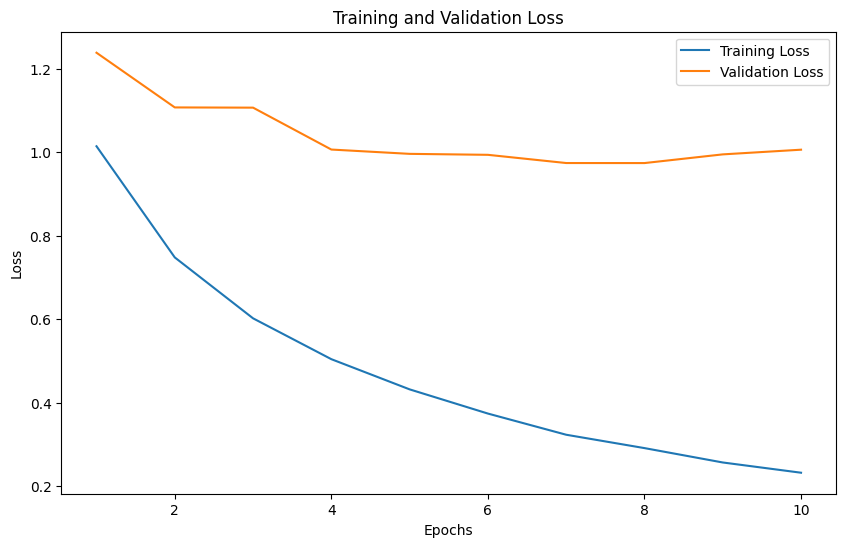

In [120]:
import matplotlib.pyplot as plt

# history 객체에 저장된 loss와 val_loss 추출
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

오버피팅이라고 판단하기에는 애매하지만, 8에포트 이후에 val_loss가 살짝 오르긴 했다.

In [ ]:
# 1. 저장된 h5 파일이 있는지 확인
weights_path = os.path.join(model_dir, "weights_epoch_10.weights.h5")

# 2. load_weights()로 직접 로드
model.load_weights(weights_path)

print("슝=3 - 로드 완료!")

슝=3 - 로드 완료!


In [85]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [86]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

/home/minho/miniconda3/envs/aiffel/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_525']]
Received: inputs=Tensor(shape=(None, None, None, 3))
  warnings.warn(msg)


슝=3


In [87]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [88]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


로컬에서 실행할 때, XLA관련 경고메시지와 함께 실행이 안되는 경우가 있어서, 환경변수 설정 후, 텐서플로우를 다시 import 했다

In [100]:
import os

# Disable XLA Auto JIT
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"

import tensorflow as tf

tf.config.optimizer.set_jit(False)

/home/minho/miniconda3/envs/aiffel/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


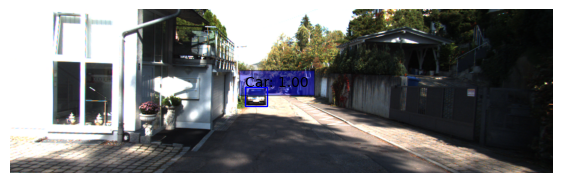

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


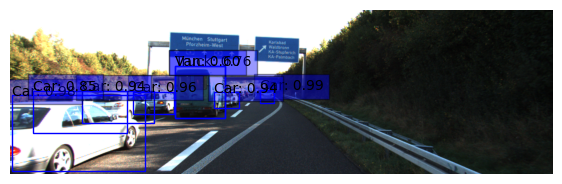

2025-03-11 03:22:52.057196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [108]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

### 루브릭의 정지 조건을 참고하여, 사람이 한명 이상 감지되거나, 차량의 크기에 따라 Stop 을 Return하게 구현했다.

In [ ]:
import os
import tensorflow as tf

def self_drive_assist(img_path, size_limit=300):
    # 파일 존재 여부 확인
    if not os.path.exists(img_path):
        return f"Error: Image file not found at path: {img_path}"
    
    # 이미지 로드 및 디코딩
    img_raw = tf.io.read_file(img_path)
    image = tf.image.decode_image(img_raw, channels=3)
    image = tf.cast(image, dtype=tf.float32)

    # 이미지 전처리
    input_image, ratio = prepare_image(image)
    
    # 모델 추론 
    detections = inference_model.predict(input_image)
    num_detections = int(detections.valid_detections[0])
    
    # 감지된 박스 좌표 복원 및 클래스 이름 변환 (int2str 함수가 정의되어 있다고 가정)
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

    # 각 감지 결과에 대해 정지 조건 검사
    for i in range(num_detections):
        name = class_names[i].lower()
        # 박스 형식이 [ymin, xmin, ymax, xmax]라고 가정
        ymin, xmin, ymax, xmax = boxes[i]
        box_width = xmax - xmin
        box_height = ymax - ymin

        # 조건 1: 사람이 한 명 이상 감지된 경우
        if "person" in name or "pedestrian" in name:
            return "Stop"

        # 조건 2: 차량(차, 트럭, 밴, 버스)의 크기가 width 또는 height가 size_limit 이상인 경우
        if name in ["car", "truck", "van", "bus"]:
            if box_width >= size_limit or box_height >= size_limit:
                return "Stop"
                
    # 위 조건에 해당되지 않으면 "Go" 반환
    return "Go"

# 올바른 이미지 경로로 수정
img_path = '/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data/stop_1.png'
print(self_drive_assist(img_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Stop


### 라벨링 된 10개에 대해 실험을 진행

In [113]:
import os
import tensorflow as tf

def test_system(func):
    # 이미지들이 모두 같은 폴더에 있으므로 해당 경로를 지정합니다.
    work_dir = '/home/minho/AIFFEL_quest_rs/GoingDeeper/Quest05/data'
    score = 0
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = os.path.join(work_dir, image_file)
        pred = func(image_path)
        print(f"File: {image_file} - Expected: {answer}, Predicted: {pred}")
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

# 테스트 실행
test_system(self_drive_assist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
File: stop_1.png - Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
File: stop_2.png - Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
File: stop_3.png - Expected: Stop, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
File: stop_4.png - Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
File: stop_5.png - Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
File: go_1.png - Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
File: go_2.png - Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
File: go_3.png - Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
File: go_4.png - Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
File: go_5.png - Expected: Go, Predicted: Go
90점입니다.


### 데이터셋 10개에 대해서는 90점을 달성하였다.

### 데이터셋에 있는 정보를 토대로, 정지조건을 적용하여 라벨링을 진행한 후, 100개의 샘플에 대해 추가 실험을 진행했다. 

In [122]:
import os
import tensorflow as tf
import tempfile
from PIL import Image
import tensorflow_datasets as tfds

def compute_expected_label(sample, size_limit=300):
    """
    어노테이션 정보를 기반으로 expected label을 산출합니다.
    조건:
      - 사람이 하나 이상 존재하거나
      - 차량(차, 트럭, 밴, 버스)의 너비 또는 높이가 size_limit(px) 이상이면 "Stop"
      - 그렇지 않으면 "Go"
    """
    image = sample["image"]
    h, w, _ = image.shape
    bboxes = sample["objects"]["bbox"]  # 정규화된 좌표 [ymin, xmin, ymax, xmax]
    types = sample["objects"]["type"]
    
    for bbox, obj_type in zip(bboxes, types):
        # int2str 함수는 KITTI 라벨 인덱스를 문자열로 변환
        label = int2str(int(obj_type)).lower()
        ymin, xmin, ymax, xmax = bbox
        abs_width = (xmax - xmin) * w
        abs_height = (ymax - ymin) * h
        if "person" in label or "pedestrian" in label:
            return "Stop"
        if label in ["car", "truck", "van", "bus"]:
            if abs_width >= size_limit or abs_height >= size_limit:
                return "Stop"
    return "Go"

def test_system_dataset_from_ds_train(ds_test, func, num_samples=100, size_limit=300):
    """
    이미 로드된 ds_train에서 num_samples개의 샘플을 가져와,
    각 이미지의 어노테이션으로 expected label("Stop" 또는 "Go")을 산출한 후
    self_drive_assist 함수의 예측 결과와 비교
    """
    ds_samples = ds_test.take(num_samples)
    
    score = 0
    total = 0
    for sample in tfds.as_numpy(ds_samples):
        expected = compute_expected_label(sample, size_limit=size_limit)
        # self_drive_assist는 이미지 경로를 입력받으므로, 임시 파일에 저장
        img = sample["image"]
        temp_dir = tempfile.gettempdir()
        temp_path = os.path.join(temp_dir, "temp_image.png")
        im = Image.fromarray(img)
        im.save(temp_path)
        
        pred = func(temp_path, size_limit=size_limit)
        print(f"Sample {total+1}: Expected: {expected}, Predicted: {pred}")
        if pred == expected:
            score += 1
        total += 1
    print(f"\nAccuracy: {score/total*100:.2f}% (score: {score}/{total})")

# ds_train은 이미 위에서 불러와진 상태라고 가정
# 예: ds_train = tfds.load("kitti", split="train", shuffle_files=True, download=False)

test_system_dataset_from_ds_train(ds_test, self_drive_assist, num_samples=100)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/home/minho/miniconda3/envs/aiffel/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/minho/miniconda3/envs/aiffel/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_525']]
Received: inputs=Tensor(shape=(1, 512, 1408, 3))
  warnings.warn(msg)


Sample 1: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Sample 2: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Sample 3: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Sample 4: Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Sample 5: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Sample 6: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Sample 7: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Sample 8: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Sample 9: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Sample 10: Expected: Stop, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Sample 11: Expected: Stop, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Sample 12: Expected: Stop, Predicted: Stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Sample 13: Expected: Go, Predicted: Go
1/1 ━━━━━━━━━━━━━━━━━━

2025-03-11 10:24:19.177023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 회고
1. 학습이 오래걸린 편인 프로젝트였는데, 로컬에서 환경 세팅해서 진행하느라 오히려 시간을 더 잡아먹은 점이 아쉽다
2. 테스트하는 데이터 셋을 직접 코드를 통해 라벨링 하여 실험을 진행한 부분이 가장 재밌었다.
3. 직접 모델이 판단하기에 어려워 보이는 부분에 대해 사람이 라벨링 하여 테스트를 해보는 것도 진행해보고 싶다.
4. Metric을 통한 평가를 진행하지 못해서, 그 부분에 대한 구현도 추가하고 싶다.